# Statuses total time
Sums the times instances spend in one of each states in the diagram saved as
"statuses.drawio". Unknown times are summed as "unknown"

In [1]:
import json
import sys
import pandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# QUEUE = set(["0-2", "1-2", "assumptions:", "1-1", "1-0"])
# RESUB = set(["4-1", "4-0", "5-1", "6-1", "7-1", "8-1", "assumptions:", "5-0", "6-0", "7-0", \
#   "8-0"])
# READY = set(["0-3", "2-3", "0-9", "2-9", "9-3", "2-7", "2-8", "9-7", "9-8", \
#   "9-9", "0-7", "0-8", "assumptions:", "2-0", "2-4", "9-4", "9-1"])
# RUN = set(["3-1", "3-10", "3-4", "3-5", "3-6", "3-7", "3-8", "10-5", "10-6", \
#   "10-7", "10-8", "10-4", "10-10", "10-1", "assumptions:", "3-0", "10-0", "3-3"])

QUEUE = set(["0-2", "1-2"])
ENDED = set(["5-1", "6-1", "7-1", "8-1"])
READY = set(["0-3", "0-9", "2-3", "2-9", "9-3", "9-9"])
RUN = set(["3-1", "3-4", "3-5", "3-6", "3-7", "3-8", "3-10", "10-1", "10-4", "10-5", "10-6", "10-7", "10-8", "10-10"])
EVICT = set(["4-1", "4-0"])

In [78]:
def to_name(et):
    if et == 4: 
        return 'EVICT'
    elif et == 5: 
        return 'FAIL'
    elif et == 6:
        return 'FINISH'
    elif et == 7:
        return 'KILL'
    elif et == 8:
        return 'LOST'
    else:
        return 'NO_TERM'

def create_df(cluster):
    obj = {}

    filename="/home/claudio/google_2019/thesis_queries/machine_time_waste/" + cluster + "_state_changes.json"

    with open(filename, 'r') as f:
        obj = json.loads(f.read())
    
    data = {'Last termination': [], 'time_type': [], 'time_ms': []}
    totals = {}
    
    def add_record(et, tt, time):
        data['Last termination'].append(to_name(et))
        data['time_type'].append(tt)
        data['time_ms'].append(time)

    for pair in obj["data"]:
        qt = et = rt = xt = vt = ut = 0

        pair[0] = 0 if pair[0] is None else pair[0]

        x = pair[1]
        for k in x.keys():
            if k in QUEUE:
                qt += x[k]
            elif k in ENDED:
                et += x[k]
            elif k in READY:
                rt += x[k]
            elif k in RUN:
                xt += x[k]
            elif k in EVICT:
                vt += x[k]
            else:
                ut += x[k]

        add_record(pair[0], 'queued', qt)
        add_record(pair[0], 'ended', et)
        add_record(pair[0], 'ready', rt)
        add_record(pair[0], 'running', xt)
        add_record(pair[0], 'evicted', vt)
        add_record(pair[0], 'unknown', ut)
        totals[pair[0]] = qt + et + rt + xt + vt + ut
        
    return (pandas.DataFrame(data, columns=['Last termination', 'time_type', 'time_ms']), totals)

## Graph 1: Absolute total time spent per status per "last termination" type

In [82]:
def graph_1(df, cluster):
    sns.set_theme(style="ticks")
    g = sns.histplot(df, x="Last termination", weights="time_ms", shrink=.5,
                 hue="time_type", multiple="dodge", discrete=True)
    g.set_yscale("log")
    g.set_ylabel("Total microseconds") 
    g.set_title("Cluster " + cluster + ": Absolute total time spent per status per \"last termination\" type")
    #g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Graph 2: Relative total time spent per status per "last termination" type

Values are proportions on total for each "last termination" type

In [83]:
def graph_2(df, cluster, totals):
    df = df.copy()
    for i in [0,4,5,6,7,8]:
        df.loc[df["Last termination"] == to_name(i), "time_ms"] = df["time_ms"][df["Last termination"] == to_name(i)] / totals[i]

    h = sns.histplot(df, x="Last termination", 
                     weights="time_ms", shrink=.5, common_bins=True,
                     hue="time_type", multiple="stack", discrete=True)
    fig, ax = plt.subplots()
    #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    h.set_title("Cluster " + cluster + ": Relative total time spent per status per \"last termination\" type") 

/home/claudio/python-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


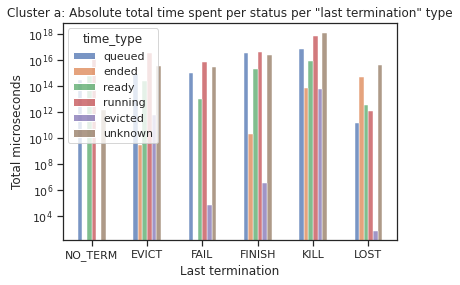

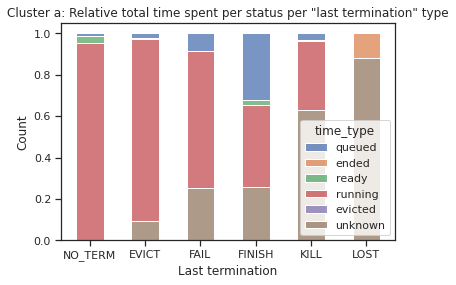

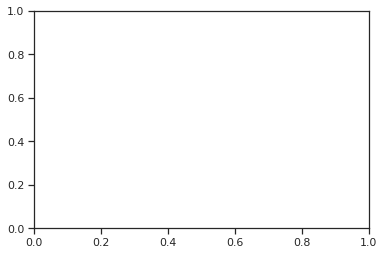

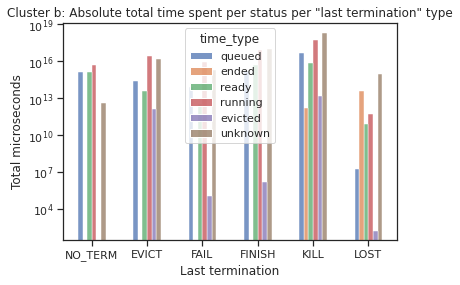

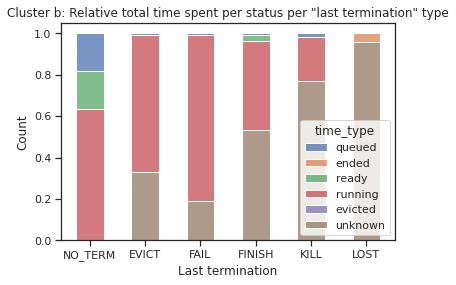

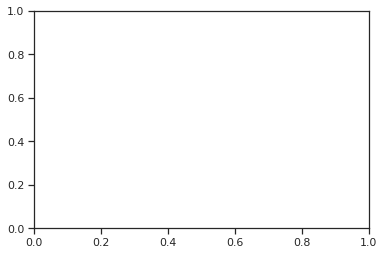

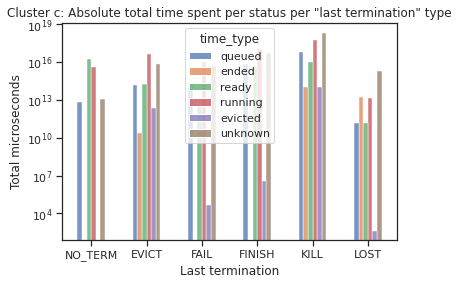

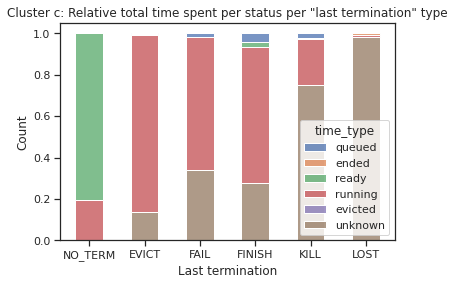

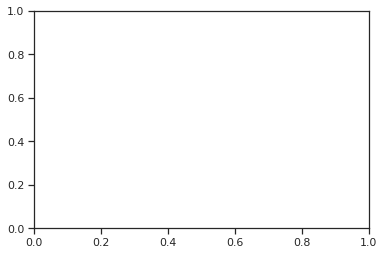

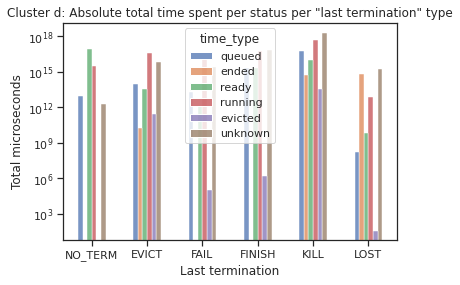

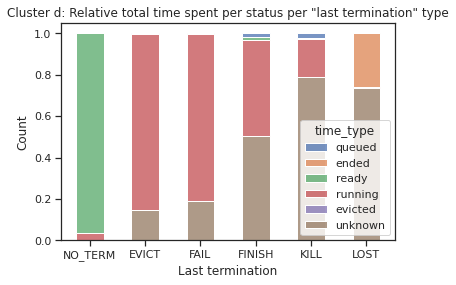

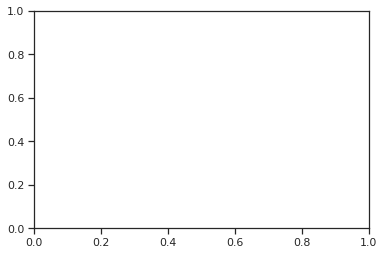

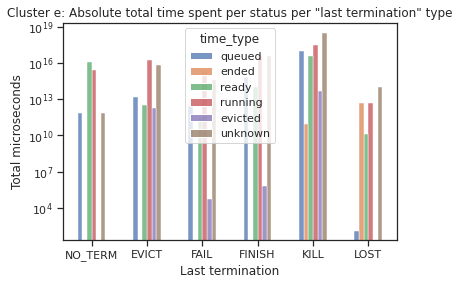

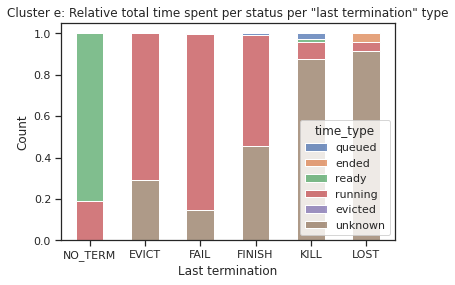

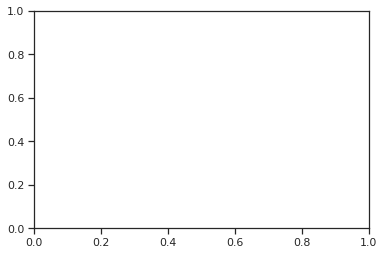

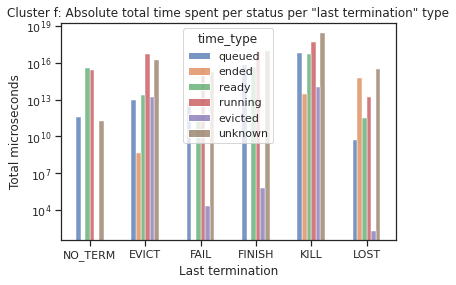

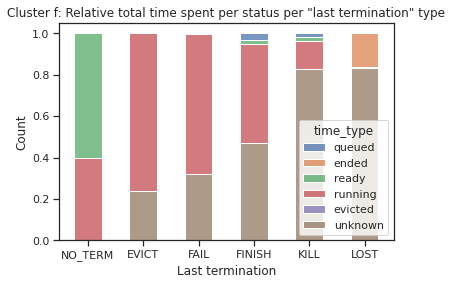

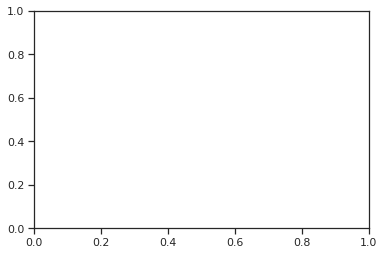

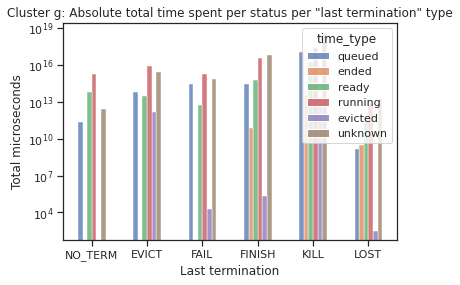

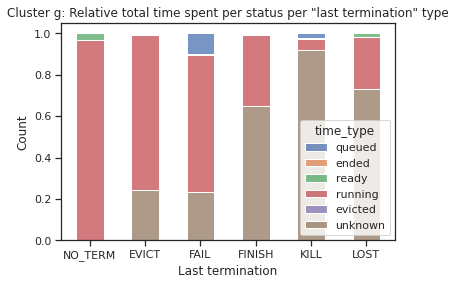

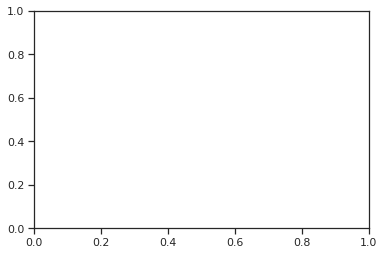

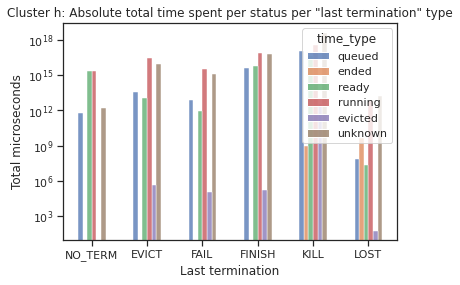

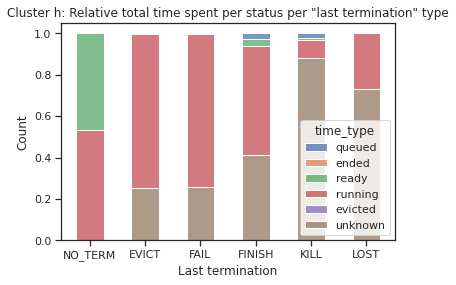

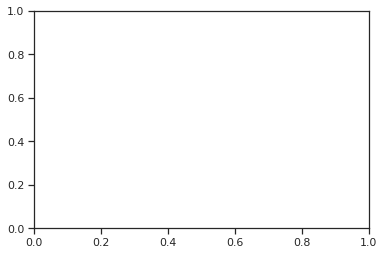

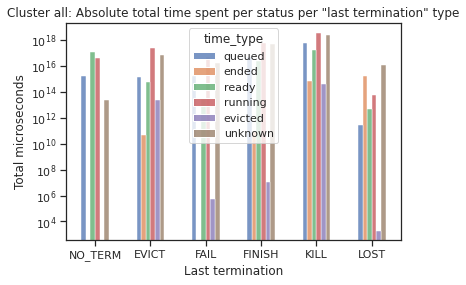

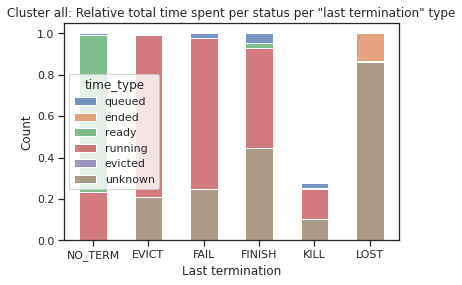

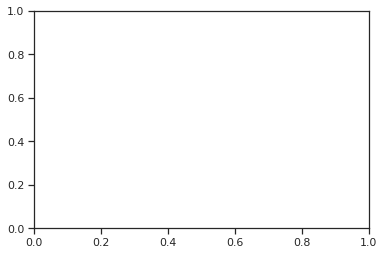

In [84]:
dft = None
tts = None

for cluster in "abcdefgh":
    df, totals = create_df(cluster)
    graph_1(df, cluster)
    plt.figure()
    graph_2(df, cluster, totals)
    plt.figure()
    
    if dft is None:
        dft = df
        tts = totals
    else:
        dft.loc[:, "time_ms"] = dft["time_ms"].add(df["time_ms"], fill_value=0)
        for key in totals:
            tts[key] += totals[key]
        
graph_1(dft, "all")
plt.figure()
graph_2(dft, "all", tts)

In [85]:
dft

Last termination time_type              time_ms
0           NO_TERM    queued     1699297448488984
1           NO_TERM     ended                    0
2           NO_TERM     ready   125206711192446239
3           NO_TERM   running    38422265478853144
4           NO_TERM   evicted                    0
5           NO_TERM   unknown       23419631884996
6             EVICT    queued     1435821272661726
7             EVICT     ended          47675802186
8             EVICT     ready      560627352043828
9             EVICT   running   250411263386366629
10            EVICT   evicted       22829884749530
11            EVICT   unknown    67267757697376575
12             FAIL    queued     1578510135252959
13             FAIL     ended                    0
14             FAIL     ready       26139149330305
15             FAIL   running    48338511089399230
16             FAIL   evicted               557255
17             FAIL   unknown    16599969189378396
18           FINISH    queued    53576662501368320
19           FINISH     ended          85816274414
20           FINISH     ready    24400884339346191
21           FINISH   running   551150109458054816
22           FINISH   evicted             11507599
23           FINISH   unknown   505479685280501015
24             KILL    queued   616978559668414433
25             KILL     ended      760262369583642
26             KILL     ready   180362665151474149
27             KILL   running  3653008453309109098
28             KILL   evicted      391227515104446
29             KILL   unknown  2655091526754536598
30             LOST    queued         286647827559
31             LOST     ended     1830379457905173
32             LOST     ready        4515413933134
33             LOST   running       56717065233915
34             LOST   evicted                 2014
35             LOST   unknown    11733560670807780